# Modeling 

**Baseline Model:** Basic NN<br>
**Tested Models:** XGBoost, Neural Networks (Keras)


---

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import networkx as nx
import random
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow import random as r
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Concatenate, Multiply
from keras import regularizers
from keras.initializers import RandomNormal
from keras.layers import Embedding, Flatten, Add, Conv2D, Reshape, Conv1D
from keras.models import load_model
from keras.regularizers import l2
import keras.backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.utils.vis_utils import plot_model

from scipy.sparse.linalg import svds
from sklearn.metrics import pairwise_distances, roc_auc_score,plot_roc_curve, log_loss, RocCurveDisplay, r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm

#fixed an issue that would kill the kernel when fitting xgboost model
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings("ignore")


/Users/jayrussell/opt/anaconda3/envs/tflow/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/jayrussell/opt/anaconda3/envs/tflow/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import utils

In [3]:
#applying seeds for consistent results
seed(42)
r.set_seed(42)

In [4]:
known_drugs = pd.read_csv('../data/cleaned data/known_drugs.csv')
lookup = pd.read_csv('../data/cleaned data/all_drugs_lookup.csv')

#drug*chemical_structure matrix
chem_sim_m = pd.read_csv('../data/cleaned data/chem_sim_m.csv')
known_drugs_names = pd.read_csv('../data/cleaned data/known_drugs_names.csv')

## Train and Test Sets

The definition of the train and test sets are important in establishing the problem. With the current dataset of known DDIs, I decide to define the test set as the future at T1, and the train set to be a previous verion of the known DDIs at T. The train set will comprise of the same selections of drugs with known DDIs taken out. This will create a hypothetical situation where we have undiscovered drug interactions at T, to predict the potential drug interactions at time T1. 


### Method:
The test set will be represented by the currently known DDIs. The Train set will have a certain amount of edges (established interactions) pulled out of it to artificially represent an earlier time period where these drug interactions haven't been discovered yet. With 89008 DDIs, I've chosen to remove around 20,000 for the train set. The objective of the model is to predict that these 20,000 drug-drug relationships are actual interactions.

**X_train** = known and unknown interactions at T <br>
**X_test** = known and unknown interactions at T1<br>
**y_train** = interaction(1), no interaction/ undiscovered (0)... <br>
**y_test** = interaction(1), no interaction/ undiscovered (0)...

### 1. Train<br>

**i. Avoid removing nodes with only 1 interaction**

In [5]:
a = known_drugs['druga_id']
b = known_drugs['drugb_id']

#stacking all instances of nodes 
nodes = pd.concat([a, b], axis = 0)

#the amount of times the nodes appear
nodes_count = nodes.value_counts().to_frame()
nodes_count = nodes_count.reset_index()

#finding the instances where the node appears only once
lonely_nodes = nodes_count[nodes_count[0] == 1]
#drop duplicates
avoid_nodes = list(set(lonely_nodes['index']))

In [6]:
#24 nodes only have 1 interaction
len(avoid_nodes)

24

**ii. Create interaction canditate pool by excluding nodes to avoid**<br>
We have to consider both columns in known_drugs as there may be drugs that appear on both sides.

In [7]:
#finding interactions to avoid
avoid = known_drugs.loc[(known_drugs['druga_id'].isin(avoid_nodes))]
avoid2= known_drugs.loc[known_drugs['drugb_id'].isin(avoid_nodes)]

#df of interactions to avoid
avoid = pd.concat([avoid,avoid2], axis = 0) 
avoid = avoid.drop_duplicates()

In [8]:
#exracting index of drugs to avoid
avoid_index = list(avoid.index.values)

In [9]:
candidates = known_drugs.copy()

#dropping the interactions to avoid
candidates = candidates.drop(candidates.index[avoid_index])

In [10]:
candidates.shape

(88984, 2)

**iii. Sampling 20,000 less samples**<br>

In [11]:
#taking 20,000 less known drug interactions compared to test set
X_train_df = candidates.sample(n=known_drugs.shape[0]-20000)


In [12]:
len(X_train_df)

69008

**iv. Adding back the avoided interactions**<br>
The train set has -20000 + lonely_node (avoided) DDIs

In [13]:
#adding back the nodes that were avoided
X_train_df = pd.concat([X_train_df, avoid], axis = 0).reset_index(drop = True)

**iv. Adding back nodes that were lost from randomly sampling**<br>


In [14]:
#cross checking that there are there are the same unique number of drugs
def node_list(df):
    node_list = []
    for col in df.columns:
        for node in df[col]:
            node_list.append(node)
            
    #removing duplicates
    node_list = list(set(node_list))
    return node_list

In [15]:
train_nodes = node_list(X_train_df)
test_nodes = node_list(known_drugs)

In [16]:
#need to ensure that all of the nodes are present in train set
add_back = list(set(test_nodes) - set(train_nodes))

In [17]:
#adding back 1st interaction with nodes that are missing from X_train
for x in add_back:
    a = known_drugs[known_drugs['druga_id'] == x][:1]
    b = known_drugs[known_drugs['drugb_id'] == x][:1]
    X_train_df = pd.concat([X_train_df, a], axis = 0)
    X_train_df = pd.concat([X_train_df, b], axis = 0)
    

In [18]:
train_nodes = node_list(X_train_df)
test_nodes = node_list(known_drugs)

In [19]:
set(test_nodes) - set(train_nodes)

set()

In [20]:
len(X_train_df)

69032

### 2. Test Set<br>
The test set will represent the currently known DDIs from the original known_drugs dataset

In [21]:
#known_drugs are the complete set of known DDIs i.e. our test set
X_test_df = known_drugs.copy()

In [22]:
len(X_train_df), len(X_test_df)

(69032, 89008)

### 3. Feature engineering similarity features

#### Drug pair_wise distance based on chemical structures
The purpose of extracting and label encoding the chemical structures is to leverage domain knowledge. The underlying assumption is that if drug A and drug B interact to produce a specific biological effect, then drugs similar to drug A (or drug B) are likely to interact with drug B (or drug A) to produce the same effect. This alternate 'representation' of the drugs will help the model integrate all signal sources with enhanced user representation.

**i. chemical structure matrix**<br>
This matrix represents each drug as a row and their substructures as a column. With 1 as a flag that the drug contains that substructure.

In [23]:
#creating a pairwise distance matrix of drug * drug based on their chemical structures
chem_sim_m.head()

,10,11,111in,12,123i,12c,13,131i,14,15,...,oo,pt,s1,s2,sc,se,si,tl,zn,zr
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**ii. Applying pairwise distance**<br>
Based on drug chemical structures, a pairwise distance score is made which can also be interpreted as: <br> A score of 0 means that the drugs are identical.

In [24]:
pairwise_distance_m = pairwise_distances(chem_sim_m)
distance_df = pd.DataFrame(pairwise_distance_m, 
                          columns=chem_sim_m.index,
                          index= chem_sim_m.index)

In [25]:
#visualising the pairwise distance matrix
distance_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403
0,0.000000,4.472136,4.358899,4.690416,5.000000,3.464102,5.196152,4.472136,4.898979,5.567764,...,5.744563,4.795832,4.582576,4.123106,3.872983,6.000000,3.605551,5.830952,5.000000,4.000000
1,4.472136,0.000000,2.645751,3.741657,3.316625,5.656854,2.236068,4.242641,4.000000,3.000000,...,5.000000,5.196152,3.316625,3.605551,2.645751,3.464102,2.236068,4.898979,4.795832,2.000000
2,4.358899,2.645751,0.000000,3.605551,3.162278,5.744563,2.449490,3.872983,3.316625,4.242641,...,3.741657,4.472136,2.449490,3.162278,2.449490,3.316625,3.464102,3.872983,3.741657,3.605551
3,4.690416,3.741657,3.605551,0.000000,3.605551,4.898979,4.123106,3.464102,3.464102,5.000000,...,4.358899,3.605551,3.605551,3.316625,3.605551,4.242641,3.872983,4.472136,4.123106,4.242641
4,5.000000,3.316625,3.162278,3.605551,0.000000,5.567764,3.741657,3.872983,3.316625,4.242641,...,3.464102,4.242641,2.828427,2.828427,3.162278,3.872983,3.162278,3.000000,3.741657,4.358899


In [26]:
pairwise_distance_m.shape

(1404, 1404)

In [27]:
pairwise_distance_m[0,1]

4.47213595499958

#### Similarity features derived from graph objects
The Jaccard coefficient and Academic Adar are commonly used to express the similarities of nodes within a graph by considering the amount of overlapping neighbours (nodes i that connect to the same nodes as node a).<br>

**Jaccard coefficient considers:**
- The ratio of the neighbours when considering a drug pair, and the union of neighbouring sets. Takes into account neighborhood size when comparing 2 drugs. Values are between 0 and 1.
<br>

**Academic Adar:**<br>
- Also based on common neighbours but with a lower degree (neighbours who don't have many neighbours)

**i. graph objects**

In [28]:
X_train_df = X_train_df.sort_values(by = 'druga_id', ascending = True).reset_index(drop = True)
X_test_df = X_train_df.sort_values(by = 'druga_id', ascending = True).reset_index(drop = True)

In [29]:
#creating graph object
train_graph = nx.from_pandas_edgelist(X_train_df, "druga_id", "drugb_id", create_using=nx.Graph())

In [30]:
test_graph = nx.from_pandas_edgelist(X_test_df, "druga_id", "drugb_id", create_using=nx.Graph())

In [31]:
edges_train = [(a, b) for a in train_graph.nodes() for b in train_graph.nodes() if b>=a]
edges_test = [(a, b) for a in test_graph.nodes() for b in test_graph.nodes() if b>=a] 

**ii. Collecting Jaccard Coefficients with utils.py**<br>

In [32]:
jac_train, jac_test = utils.jac(train_graph, test_graph, edges_train, edges_test)

In [33]:
jac_train.head()

JAC
0 1             
0 0     1.000000
  1257  0.021277
  1305  0.025090
  624   0.019523
  945   0.073171

In [34]:
jac_train.loc[0]

,JAC
1,
0,1.000000
1257,0.021277
1305,0.025090
624,0.019523
945,0.073171
...,...
1338,0.006098
1370,0.000000
1340,0.000000


**iii. Acadamic Adar Coefficients (AAC)**<br>
The Acadamic adar takes divides by the log(degree), meaning that it runs into error with mirror node pairs. A node cannot be a common neighbour with a degree of 1 (only interacting with node a). The only case of this is when a node is being compared to itself.

In [35]:
aac_train, aac_test = utils.aac(train_graph, test_graph, edges_train, edges_test)

In [36]:
aac_train.head()

AAC
0 1             
0 0     0.000000
  1257  1.277494
  1305  1.272352
  624   1.652152
  945   1.066692

### 4. Positive and Negative samples (X_train, X_test)
Positive and negative samples are both needed to train the model. Since the data only contains known DDIs, it only has positive samples. We need to extract all of the interactions that are negative (unknown) in our train and test sets. This can be achieved by creating an adjacency matrix for both sets, and locating the drug-pairs where a 0 exists.

**i.Creating an adjacency matrix**<br>
The resulting matrices will allow us to extract negative samples that will be used to manipulate the composition of our train set. each matrix will represent drug x drug columns and rows, with observations as 1 for interaction, 0 for no interaction. 

In [37]:
# converts df representing DDI into adjacency matrix
def matrix(df, g): #g = nx graph object
    #creating a list of the nodes present
    node_list = []
    for col in df.columns:
        for node in df[col]:
            node_list.append(node)
            
    #removing duplicates
    node_list = list(set(node_list))
    
    #creating numpy matrix from the graph
    adj_m = nx.to_numpy_matrix(g, nodelist = node_list)
    return adj_m

DDI matrices:

In [38]:
train_adj_m = matrix(X_train_df, train_graph)
test_adj_m = matrix(X_test_df, test_graph)

In [39]:
#same shape, same selection of drugs
train_adj_m.shape, test_adj_m.shape

((1404, 1404), (1404, 1404))

**iii. Extracting positive and negative values from adjacency matrix**

In [40]:
#extract the indices of pos and neg pairs
def pos_neg(matrix):
    
    #accessing the index of positive samples from adjacency matrix
    pos = list(np.where(matrix == 1))
    
    #accessing the index negative samples from adjacency matrix
    neg = list(np.where(matrix == 0))
    
    return pos, neg

In [41]:
X_train_pos, X_train_neg = pos_neg(train_adj_m)
X_test_pos, X_test_neg = pos_neg(test_adj_m)

In [42]:
X_train_pos

[array([   0,    0,    0, ..., 1403, 1403, 1403]),
 array([ 174,  282,  451, ..., 1333, 1335, 1388])]

### 5. Creating train and test sets with pos/neg composition <br>
The model needs to be trained with a number of negative samples. <br>

**Positive** = known interactions (1)<br>
**Negative** = unknown interactions (0)<br>


The balance of the classes for this binary problem will be determined by this function:<br>

In [43]:
def nodes_into_tuples(a, b):
    return list(zip(a, b))

In [44]:
X_train_pos_tuples= nodes_into_tuples(X_train_pos[0],X_train_pos[1])
X_train_neg_tuples = nodes_into_tuples(X_train_neg[0],X_train_neg[1])

X_test_pos_tuples = nodes_into_tuples(X_test_pos[0],X_test_pos[1])
X_test_neg_tuples = nodes_into_tuples(X_test_neg[0],X_test_neg[1])

In [45]:
#altering the composition of the train set depending on the chosen negative to positive ratio
def input_neg_samples(X_pos, X_neg, neg_ratio):
    train = list(X_pos)
    
    #takes random subset of negative samples and adds it to the train set
    #1 = 1 neg for 1 positive
    train += random.sample(X_neg, int(len(X_pos) * neg_ratio))
    
    return train

In [46]:
#train will have 1 to 1 ratio to achieve a balanced train set containing 50:50 positive and negative samples
X_train_tuples = input_neg_samples(X_train_pos_tuples,X_train_neg_tuples, 1)

#the test data will represent the entire DDI matrix with all negative and positive samples
X_test_tuples = X_test_pos_tuples + X_test_neg_tuples

In [47]:
#X_test includes all negative samples, meaning that there will be a way larger amount of inputs for the test set
len(X_train_tuples), len(X_test_tuples)

(276128, 1971216)

### 6. Features

In [48]:
len(X_train_tuples)

276128

In [49]:
len(X_test_tuples)

1971216

In [50]:
jac_train.tail()

JAC
0    1             
1378 1389  0.020000
     1399  0.005848
     1400  0.000000
     1387  0.000000
     1378  1.000000

In [51]:
X_train_features, X_test_features = utils.extract_features(X_train_tuples, X_test_tuples, pairwise_distance_m, jac_train, jac_test, aac_train, aac_test)

**ii. Pre-processing**

For XGBoost (dataframe):

In [52]:
#After pos neg ratio implimented, returning X_train and X_test into df
X_train_df = pd.DataFrame(X_train_tuples, columns = ['node_a', 'node_b'])
X_test_df = pd.DataFrame(X_test_tuples, columns = ['node_a', 'node_b'])

In [53]:
#adding features to train test dfs
X_train_df = pd.concat([X_train_df, X_train_features],axis = 1)
X_test_df = pd.concat([X_test_df, X_test_features],axis = 1)

In [54]:
X_train_df.tail()

,node_a,node_b,parwise_distance,JAC,AAC
276123,339,330,2.645751,0.074510,3.321223
276124,51,721,4.000000,0.012987,0.171644
276125,532,868,3.000000,0.046053,1.185934
276126,895,563,2.828427,0.000000,0.000000
276127,199,749,5.000000,0.007042,0.165040


In [55]:
X_train_df.to_csv('../data/cleaned data/X_train.csv', index = False)
X_test_df.to_csv('../data/cleaned data/X_test.csv', index = False)

Neural Network (arrays):

**One hot encoding representations of each node**<br>
i.e. node 0 will be [1,0,0,0,0... i]. Necessary because there's no ordinal relationship between the nodes.

In [56]:
#converts an array of ints into a one hot code representation of each number
# def ohe_array(tuples):
#     to_list = []
#     #turning them into arrays
#     a = np.array([x[0] for x in tuples])
#     b = np.array([x[1] for x in tuples])
    
#     #one hot encoding array with np.zeros
#     #code from Mateen Ulhaq
#     c = np.zeros((a.size, a.max() + 1))
#     c[np.arange(a.size), a] = 1
    
#     d = np.zeros((b.size, b.max() + 1))
#     d[np.arange(b.size), b] = 1
    
#     # one hot encoding
#     to_list.append(c)
#     to_list.append(d)
#     return to_list

In [57]:
def to_array(tuples):
    to_list = []
    #turning them into arrays
    to_list.append(np.array([x[0] for x in tuples]))
    to_list.append(np.array([x[1] for x in tuples]))
    return to_list

In [58]:
# X_train_nn = ohe_array(X_train_tuples)
# X_test_nn = ohe_array(X_test_tuples)

In [59]:
X_train_nn = to_array(X_train_tuples)
X_test_nn = to_array(X_test_tuples)

In [60]:
X_train_nn

[array([  0,   0,   0, ..., 532, 895, 199]),
 array([174, 282, 451, ..., 868, 563, 749])]

### 7. y_train, y_test
Target label is accessed from their adjacency matrices.

Neural Network:

In [61]:
#accessing the adj matrix to find target (interaction = 1, no interaction = 0)
y_train_nn = np.array([[train_adj_m[x[0], x[1]]] for x in X_train_tuples])
y_test_nn = np.array([[test_adj_m[x[0], x[1]]] for x in X_test_tuples])

Other models (XGBoost, logistic regression)

In [62]:
#y_train, y_test
y_train_df = pd.DataFrame(y_train_nn, columns = ['interaction'])
y_test_df = pd.DataFrame(y_test_nn, columns = ['interaction'])

In [63]:
y_train_df.to_csv('../data/cleaned data/y_train.csv', index = False)
y_test_df.to_csv('../data/cleaned data/y_test.csv', index = False)

In [64]:
X_train_df.shape, y_train_df.shape, X_test_df.shape, y_test_df.shape

((276128, 5), (276128, 1), (1971216, 5), (1971216, 1))

## Model 1: Deep Learning Neural Networks 
The approach that I've taken is to combine 2 subnetworks that are 2 approaches that explore the relationship of the drug pairs with addition and multiplication
. This model is only reliant on DDIs,(node_a, node_b), and will define their relationships through embeddings that represent the 2 subnetworks.<br>

### Model layout
**Input layers**
2 inidividual input layers to represent each node

**Embedding layers**<br>
There are 2 embedding layers:<br>
- Addition 
- Multiplication

Creates random vectors from the 2 inputs (drugs) that will represent the relationship of the inputs. The generated vectors are latent factors within a new latent space that explores the relationship of the drugs in a non-linear environment. This allows the discovered relationships between the drugs to be a lot more expressive. The size of the embedding vectors denoted by k will decide wether these outputs include more or less information within the vectors, therefore being an optimization tool to combat overfitting and underfitting. 

The difference between the 2 layers is how it explores the relationship between the 2 drugs:<br>

*Addition Layer*<br>
The additional embedding layer will be a very basic subnetwork that takes in the 2 inputs, apply some regularization with a low k, then apply addition to the 2 sub embeddings. The output will be a simple representation of the interaction to increase generalisation for the model.

*Multiplication Layer*<br>
The Multiplication embeddings will include regularisation, dropouts, have a higher k to then eventually get the product of the 2 sub embeddings. This output will have a more informative interaction term between the 2 nodes. Intuition behind this is that the dot product exaggerates the similarities and differences (big * big = bigger; small * small = smaller).


**Concatenated layer, Output layer**<br>
The 2 final embeddings are then concatented and fed into the final output layer that is activated with the 'sigmoid' function to apply a binary classifiction: 1 = interaction, 0 = no interaction.

In [65]:
#input layers will represent drug_a and drug_b
#2 separate inputs that will be combined later in embeddings
input_node_a = Input(shape=(1,), name='b')
input_node_b = Input(shape=(1,), name='c')

#addition layer
#k = 1
mlp_emb = Embedding(output_dim=1, name='Addition',input_dim=train_adj_m.shape[0], embeddings_regularizer=l2(0.1))

#embedding for each node
emb_mlp1 = mlp_emb(input_node_a)
emb_mlp2 = mlp_emb(input_node_b)

#combining 2 inputs with addition so that there's 1 combined embedding
l_mlp = Add()([emb_mlp1,emb_mlp2])

#-----------

#multiplication layer
#k = 200
mult_dense = Embedding(output_dim= 200, name='Multiplication',embeddings_regularizer=l2(0.1),input_dim=train_adj_m.shape[0]) 
emb_mult1 = mult_dense(input_node_a)
emb_mult2 = mult_dense(input_node_b)

#dropout layer for each mult embedding
dr_emb_mult1 = Dropout(0.3)(emb_mult1)
dr_emb_mult2 = Dropout(0.3)(emb_mult2)

#combining 2 embeddings with multiplication to create 1 combined embedding
#dropout(0) is just an identity operation, no dropout is being performed
mult = Dropout(0)(Multiply()([dr_emb_mult1, dr_emb_mult2]))

#-----------

#flattening the embedding layers for formatting
l_mlp = Flatten()(l_mlp)
mult = Flatten()(mult)

#Concatenate layer that combines MLP and multiplied layer into a single tensor
final_layers = Concatenate(axis=-1)([l_mlp, mult])

#-----------

#output layer
main_output= Dense(1, activation='sigmoid')(final_layers)

#instantiate model with inputs being the 2 input nodes, output as a dense layer of the concatenated embeddings (combined inputs)
model_emb = Model(inputs=[input_node_a,input_node_b], outputs=main_output)

#compiling model with adam optimizer, loss function as binary_crossentropy, success metric as accuracy
model_emb.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


**Structure of the neural network:**<br>

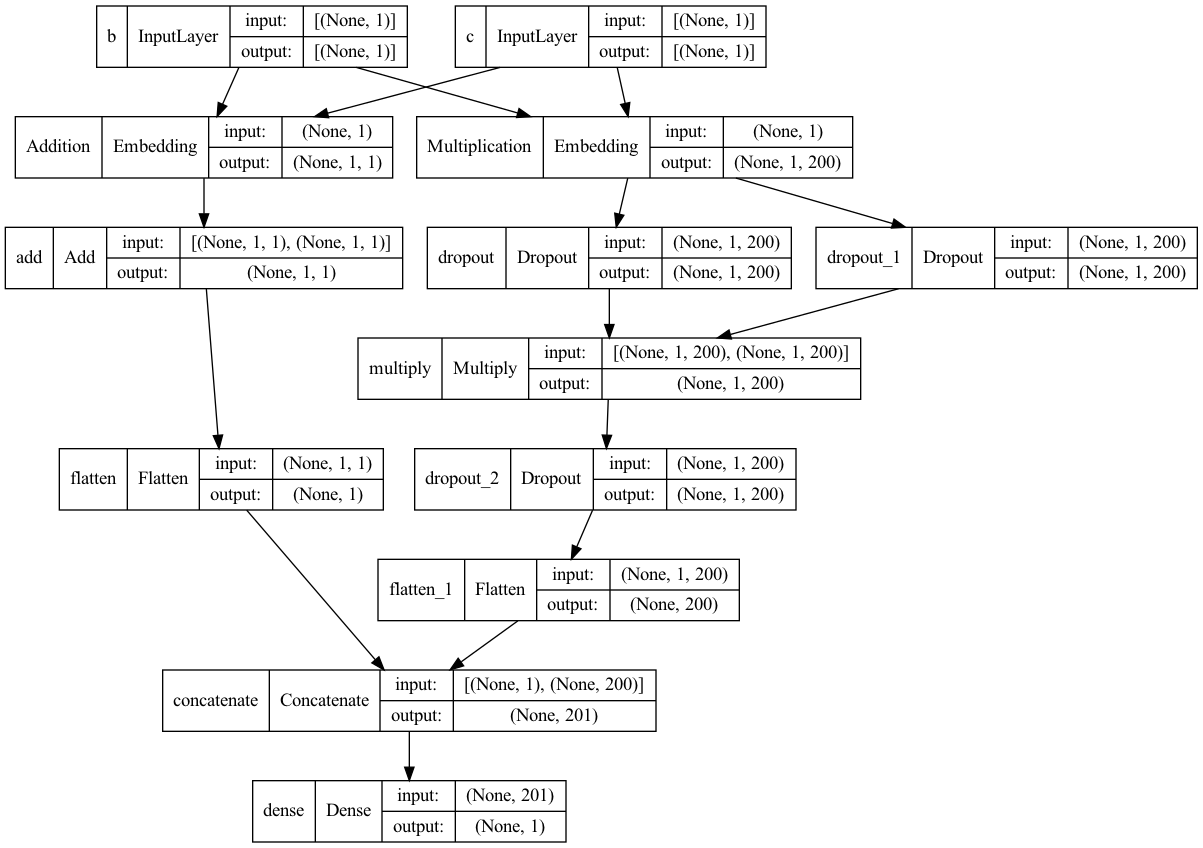

In [66]:
plot_model(model_emb, show_shapes=True, show_layer_names=True)

In [67]:
#implimenting a high tolerance for early stopping to take action with patience = 5
early_stop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1)

In [68]:
history = model_emb.fit(
    X_train_nn, y_train_nn,
    validation_data = (X_test_nn, y_test_nn),
    epochs= 20,
    batch_size = 280,
callbacks= [early_stop])

Epoch 1/20
987/987 [==============================] - 6s 5ms/step - loss: 1.0259 - accuracy: 0.5248 - val_loss: 0.6932 - val_accuracy: 0.7144
Epoch 2/20
987/987 [==============================] - 5s 5ms/step - loss: 0.6926 - accuracy: 0.6716 - val_loss: 0.6859 - val_accuracy: 0.8626
Epoch 3/20
987/987 [==============================] - 5s 5ms/step - loss: 0.6902 - accuracy: 0.7210 - val_loss: 0.6883 - val_accuracy: 0.7678
Epoch 4/20
987/987 [==============================] - 5s 5ms/step - loss: 0.6867 - accuracy: 0.7348 - val_loss: 0.6901 - val_accuracy: 0.7147
Epoch 5/20
987/987 [==============================] - 5s 5ms/step - loss: 0.6826 - accuracy: 0.7429 - val_loss: 0.6782 - val_accuracy: 0.7767
Epoch 6/20
987/987 [==============================] - 5s 5ms/step - loss: 0.6780 - accuracy: 0.7457 - val_loss: 0.6826 - val_accuracy: 0.7341
Epoch 7/20
987/987 [==============================] - 5s 5ms/step - loss: 0.6731 - accuracy: 0.7484 - val_loss: 0.6675 - val_accuracy: 0.7774
Epoch 

## Model 2: XGBoost<br>
The XGBoost model will be receiving inputs that represent the similarities between the drugs derived from a graph object (Jacard coefficients, acadamic adar coefficients, pairwise distances). 

**Best params:**
{'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'learning_rate': 1e-05,
 'max_depth': 4,
 'subsample': 0.1}

In [69]:
X_train = pd.read_csv('../data/cleaned data/X_train.csv')
X_test = pd.read_csv('../data/cleaned data/X_test.csv')
y_train = pd.read_csv('../data/cleaned data/y_train.csv')
y_test = pd.read_csv('../data/cleaned data/y_test.csv')


In [70]:
#X_train, X_test
len(X_train), len(X_test)

(276128, 1971216)

In [71]:
y_train = y_train['interaction']
y_test = y_test['interaction']

In [72]:
#scale_pos_weight = 1 because we have 1 for 1 pos_neg composition in train
xgboost = XGBClassifier(scale_pos_weight = 1, n_estimators=100, random_state=42, use_label_encoder = False, objective='binary:logistic')

In [73]:
xgb_params = {'learning_rate': [0.001,0.0001,0.00001],
          'subsample': [0.05,0.1,0.2],
          'colsample_bytree': [0.5,0.75,1],
          'colsample_bylevel':[0.5,0.75,1],
          'max_depth':[2,4,6]
         }

In [74]:
xgb_gs = GridSearchCV(xgboost,
                         xgb_params,
                         cv= 5,
                         verbose = 1)

In [75]:
#incoming warnings for a while. 
xgb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[15:30:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used wi

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=False,
                                     validate_parameters=None, verbosity=None),
             param_grid={'colsample_bylevel': [0.5, 0.75, 1],
                         'colsample_bytree': [0.5, 0.75, 1],
                         'learning_rate': [0.001, 0.0001, 1e-05],
                         'max_depth': [2, 4, 6],
                         'subsample': [0.05, 0.1, 0.2]},
             verbose=1)

In [76]:
xgb_gs.best_score_

0.6366283477299428

In [77]:
xgb_gs.best_params_

{'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'learning_rate': 1e-05,
 'max_depth': 4,
 'subsample': 0.2}

In [78]:
xgb_gs.score(X_test, y_test)

0.7748100664767331

## Model 3: Logistic Regression

In [79]:
log_reg= LogisticRegression(solver = 'saga')


In [80]:
#will be tuning the regularisation on logistic regression
log_reg_params= {"C":np.logspace(-3,3,7), 
                 #lasso and ridge regularisation
                 "penalty":["l1","l2"]}

In [81]:
#LogisticRegression gridseach over params outlined previously
logreg_gs = GridSearchCV(log_reg,
                         log_reg_params,
                         cv= 5,
                         verbose = 1)

In [82]:
log_reg.fit(X_train, y_train)

LogisticRegression(solver='saga')

In [83]:
log_reg.score(X_train, y_train) , log_reg.score(X_test, y_test)

(0.7672963263414069, 0.8199720375646301)

## Baseline Model: Basic Neural Network
The Baseline Neural Network model involves embedding layers as there are 2 inputs but no regularisation.

In [84]:
#basic embedding workflow
emb = Embedding(output_dim=1, input_dim=train_adj_m.shape[0]) 
emb_a = emb(input_node_a)
emb_b = emb(input_node_b)

#combining the embeddings with multiplication
emb_final = Multiply()([emb_a, emb_b])

#flattening embedding layer
emb_final = Flatten()(emb_final)

final_output = Dense(1,
                activation='sigmoid')(emb_final)

baseline = Model(inputs=[input_node_a,input_node_b], outputs=final_output)

In [85]:
baseline.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [86]:
history_b = baseline.fit(
    X_train_nn, y_train_nn,
    validation_data = (X_test_nn, y_test_nn),
    epochs= 50,
    batch_size = None,
callbacks= [early_stop],
verbose = 1)

Epoch 1/50
8629/8629 [==============================] - 24s 3ms/step - loss: 0.5913 - accuracy: 0.6849 - val_loss: 0.5219 - val_accuracy: 0.7872
Epoch 2/50
8629/8629 [==============================] - 25s 3ms/step - loss: 0.5007 - accuracy: 0.7669 - val_loss: 0.4929 - val_accuracy: 0.7832
Epoch 3/50
8629/8629 [==============================] - 24s 3ms/step - loss: 0.4895 - accuracy: 0.7733 - val_loss: 0.5032 - val_accuracy: 0.7704
Epoch 4/50
8629/8629 [==============================] - 24s 3ms/step - loss: 0.4848 - accuracy: 0.7750 - val_loss: 0.5028 - val_accuracy: 0.7664
Epoch 5/50
8629/8629 [==============================] - 24s 3ms/step - loss: 0.4824 - accuracy: 0.7762 - val_loss: 0.4956 - val_accuracy: 0.7685
Epoch 6/50
8629/8629 [==============================] - 24s 3ms/step - loss: 0.4809 - accuracy: 0.7767 - val_loss: 0.4994 - val_accuracy: 0.7650
Epoch 7/50
8629/8629 [==============================] - 24s 3ms/step - loss: 0.4801 - accuracy: 0.7770 - val_loss: 0.4909 - val_ac

## Evaluation <br>
So the main idea of using a deep neural network is to learn a non-linear function rather than a linear one and in doing so hopefully increase the expressiveness of the final model.<br>

**Evaluation Metrics:**<br>
- Accuracy (success metric)
- Binary Cross Entropy (loss metric for NN)
- Log Loss (loss metric for XGBoost)
- ROC curve
    - Shows the trade-off of our model's performance in context to Recall and Specificity as the threshold of our predicted probabilities change.
- Area Under Curve (AUC)
    - AUC is an indication of the performance of the model across all possible classification thresholds, representing how separated our positive and negative populations are from each other. We aim to have a higher AUC as it indicates less confusion between. Looks into Recall (type 1 errors) and Specificity (type 2 errors) as they represent the ratio of our model correctly labelling the actual entries.


### Baseline
The Baseline Neural Network model lacks any type of regularisation, therefore is very prone to overfitting and is evident in the accuracy graph. The training and testing loss also reflect this. The AUC is going to be the most comparable metric between the models, therefore we are trying to beat an AUC of 0.80.

**Accuracy**

In [87]:
history_b.history['accuracy'][-1], history_b.history['val_accuracy'][-1]

(0.7794790863990784, 0.7701556086540222)

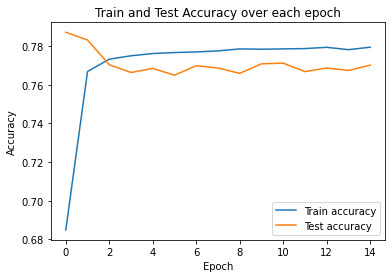

In [88]:
plt.figure(figsize=(6, 4))
plt.title('Train and Test Accuracy over each epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history_b.history['accuracy'], label= 'Train accuracy')
plt.plot(history_b.history['val_accuracy'], label= 'Test accuracy')
plt.legend()

**Loss Metric: Binary cross entropy**

In [89]:
b_train_loss = history_b.history['loss']
b_test_loss = history_b.history['val_loss']

In [90]:
history_b.history['loss'][-1], history_b.history['val_loss'][-1]

(0.47701501846313477, 0.48689255118370056)

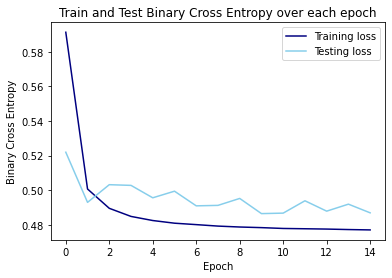

In [91]:
plt.figure(figsize=(6, 4))
plt.title('Train and Test Binary Cross Entropy over each epoch')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy')
plt.plot(b_train_loss, label='Training loss', color='navy')
plt.plot(b_test_loss, label='Testing loss', color='skyblue')
plt.legend();

**Area Under Curve (AUC)**

In [92]:
y_pred_b = baseline.predict(X_test_nn)
auc = roc_auc_score(y_test_nn, y_pred_b)
auc

0.8561276306000695

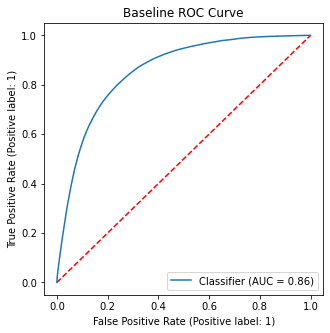

In [93]:
_, ax = plt.subplots(figsize=(5, 5))
ax.title.set_text('Baseline ROC Curve')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="red")
RocCurveDisplay.from_predictions(y_test_nn, y_pred_b, ax=ax);

### Neural Network
The model's ability to predict interactions is OK. There is minimal signs over underfitting which is ideal as it is more important to be able to predict new interactions (as well as previously discovered interactions) in the test. Minimising the loss metrics proved to be difficult, where this model wasn't able to beat the baseline. The AUC of 0.83 beats the baseline model, but XGBoost has been able to perform better with 0.87, meaning that it is more prone to classifying the interactions incorrectly.

**Accuracy**<br>
Observing the model's accuracy over each epoch reveals the progression of the model's ability to minimise overfitting. The test accuracy seems to be quite volatile at the beginning, perhaps due to the batch sizes being too small which leads to the weightings within the model being drastically adjusted at each epoch. 

In [94]:
history.history['accuracy'][-1], history.history['val_accuracy'][-1]

(0.7655000686645508, 0.7661002278327942)

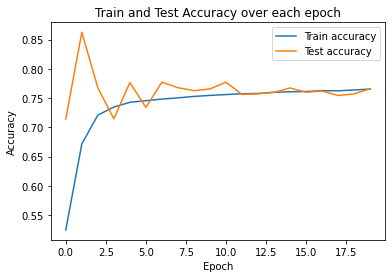

In [95]:
#visualising the train and test accuracy over each epoch
plt.figure(figsize=(6, 4))
plt.title('Train and Test Accuracy over each epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label= 'Train accuracy')
plt.plot(history.history['val_accuracy'], label= 'Test accuracy')
plt.legend()

**Error metric: Binary crossentropy**<br>
The model is able to reduce the loss metric quite rapidly, and is only able to minimise the loss function further over each epoch. 

In [96]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

In [97]:
history.history['loss'][-1], history.history['val_loss'][-1]

(0.6096011996269226, 0.604732096195221)

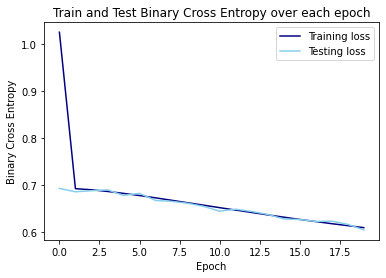

In [98]:
plt.figure(figsize=(6, 4))
plt.title('Train and Test Binary Cross Entropy over each epoch')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy')
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

**Area Under Curve (AUC)**

In [99]:
y_pred_nn = model_emb.predict(X_test_nn)
auc = roc_auc_score(y_test_nn, y_pred_nn)
auc

0.841895082247803

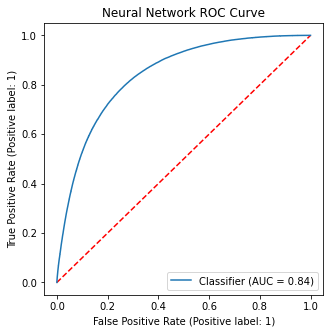

In [100]:
_, ax = plt.subplots(figsize=(5, 5))
ax.title.set_text('Neural Network ROC Curve')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="red")
RocCurveDisplay.from_predictions(y_test_nn, y_pred_nn, ax=ax);

In [101]:
y_pred_nn_r = np.round(y_pred_nn)

**Type 1 and 2 errors**

In [102]:
print(classification_report(y_test_nn, y_pred_nn_r))

              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86   1833152
         1.0       0.20      0.76      0.31    138064

    accuracy                           0.77   1971216
   macro avg       0.59      0.76      0.59   1971216
weighted avg       0.92      0.77      0.82   1971216



### XGBoost
The performance of XGboost is better than the neural network in terms of AUC, but is really prone to underfitting. The average recall is identical to the Neural Network, meaning that they are both able to classify predicted interactions correctly at the same level. 

**Accuracy**

In [103]:
xgb_gs.best_score_, xgb_gs.score(X_test, y_test)

(0.6366283477299428, 0.7748100664767331)

In [104]:
xgb_train_y_pred = xgb_gs.predict_proba(X_train)[:,1]
xgb_test_y_pred = xgb_gs.predict_proba(X_test)[:,1]

**Area Under Curve (AUC)**

In [105]:
roc_auc_score(y_test, xgb_gs.predict_proba(X_test)[:,1])

0.8731754949729988

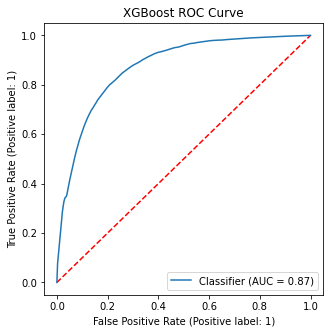

In [107]:
_, ax = plt.subplots(figsize=(5, 5))
ax.title.set_text('XGBoost ROC Curve')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="red")
RocCurveDisplay.from_predictions(y_test, xgb_test_y_pred, ax=ax);

**Type 1 and 2 errors**

In [108]:
print(classification_report(y_test, np.round((xgb_gs.predict_proba(X_test)[:,1]))))

              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86   1833152
         1.0       0.21      0.82      0.34    138064

    accuracy                           0.77   1971216
   macro avg       0.60      0.79      0.60   1971216
weighted avg       0.93      0.77      0.83   1971216



### Logistic Regression<br>

**Logistic Regression overview:**<br>
Line assumptions have not been confirmed because the features are too corrilated to each other (the features are all indications of similarity between each drug pair). The performance turned out to be a lot better than the other 2 models with a Train accuracy of 0.76 and Test of 0.82, but can't be used for comparison in the end. The loss function seems to do very well.

**Accuracy**

In [109]:
log_reg.score(X_train, y_train) , log_reg.score(X_test, y_test)

(0.7672963263414069, 0.8199720375646301)

In [110]:
logreg_train_pred = np.round(log_reg.predict_proba(X_train), 3)[:,1]
logreg_test_pred = np.round(log_reg.predict_proba(X_test), 3)[:,1]

**Loss Metric: (Root Mean Squared Error)**<br>

In [111]:
mean_squared_error(y_train, logreg_train_pred, squared= False), mean_squared_error(y_test, logreg_test_pred, squared= False)

(0.406948742375953, 0.40461462879177096)

**Area Under Curve (AUC)**

In [112]:
roc_auc_score(y_test, logreg_test_pred)

0.8442233795381192

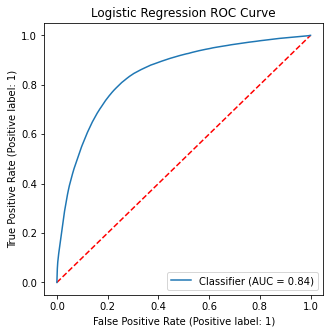

In [113]:
_, ax = plt.subplots(figsize=(5, 5))
ax.title.set_text('Logistic Regression ROC Curve')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="red")
RocCurveDisplay.from_predictions(y_test, logreg_test_pred, ax=ax);

**Type 1 and 2 errors**

In [114]:
print(classification_report(y_test, np.round((log_reg.predict_proba(X_test)[:,1]))))

              precision    recall  f1-score   support

         0.0       0.97      0.83      0.90   1833152
         1.0       0.24      0.71      0.35    138064

    accuracy                           0.82   1971216
   macro avg       0.61      0.77      0.62   1971216
weighted avg       0.92      0.82      0.86   1971216

